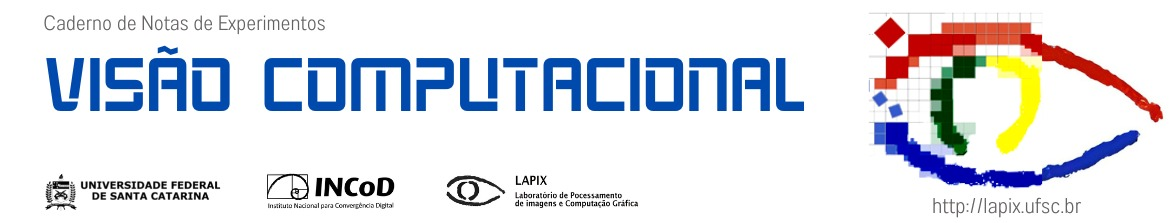







<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/02.3.Dom%C3%ADnio%20do%20Valor%20-%20Aprofundamento%20em%20Limiariza%C3%A7%C3%B5es.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-green" alt="Python Version" title="Python Version"></a>

# 02.3.Domínio do Valor - Aprofundamento em Limiarizações

Neste caderno de notas você vai se aprofundar um pouco mais em limiarização. Até agora você viu duas aplicações na área da vigilância eletrônica onde a aplicação de um limiar foi realizada de maneira muito simples e direta: simplesmente aplicamos um limiar "programado". 

E o que acontece quando há muita variação no ambiente de uma imagem e não é possível utilizar um valor de corte pré programado? É possível determinar-se, em tempo de execução de um programa, um valor de corte adaptativo?

Existem várias técnicas de limiarização onde se pondera o valor do limiar a ser utilizado com base em uma análise da distribuição dos valores de tons de cinza na imagem. Essa avaliação pode ser realizada com métodos de cálculo de histograma muito simples e que também são métodos do domínio do valor e várias bibliotecas de processamento de imagem possuem rotinas de linearização que tem estes métodos integrados. Nos exercícios abaixo nós vamos ver algumas destas rotinas, originárias de duas diferentes bibliotecas de Visão Computacional.


## Thresholds

Thresholding is used to create a binary image from a grayscale image. It is the simplest way to segment objects from a background. Thresholding algorithms implemented in scikit-image can be separated in three categories:

- **Global**: One or two cutting values are used in order to separate pixels in groups accordingly to their value only;
- **Histogram-based**: The histogram of the pixels' intensity is used and certain assumptions are made on the properties of this histogram (e.g. bimodal);
- **Adaptive/Local**: To process a pixel, only a set of neighboring pixels are used. They can be considered using a simple region ("block") operation or be based upon some simple convolution, such as a Gaussian (OpenCV only). These algorithms often require more computation time.


If you are not familiar with the details of the different algorithms and the
underlying assumptions, it is often difficult to know which algorithm will give
the best results. Therefore, Scikit-image includes a function to evaluate
thresholding algorithms provided by the library. At a glance, you can select
the best algorithm for you data without a deep understanding of their
mechanisms.

# Configurações de GPU e PATH

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [2] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

Running on Google Colab =  False


## **Se** você estiver rodando no Colab

### Cloning the ***Computer Vision*** repository from a Git

If you're running this at your computer or using Google Colab but **not** using your Google Drive, this is the way to use these notebooks! Please choose only one of the two Gits below.

In [2]:
# To clone from our personal Github mirror (may be out of sync):
if _ON_COLAB:
    !git clone https://github.com/awangenh/vision

In [3]:
# To clone from UFSC's Institutional Gitlab (always the latest version):
if _ON_COLAB:
    !git clone https://codigos.ufsc.br/aldo.vw/vision

### Mova a pasta *data* 

Move ***vision/data*** one level up, into the root folder, so the Anconda-oriented data paths in the next cells will all work properly. If you are running this notebook from a copy of the ***vision*** Git on Anaconda, you **do not** have to do this.

In [4]:
if _ON_COLAB:
    # If you are Running on Google Colab,
    # Move vision/data one level up, into the root folder
    !mv vision/data ..
    # Move all Python files to /content
    !mv vision/jupyter/*.py .

### Monte seu Google Drive como uma pasta

If you're using Google Colab together with your Google Drive, adapt this code below to point to the place where you've copied our Git in your Google Drive:

In [5]:
# Code to mount the Google Drive
if _ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    !ln -s "/content/drive/My Drive"

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Grayvalue Thresholds

### The Simplest Automated Threshold: Separate by the Mean Value (SciKit)

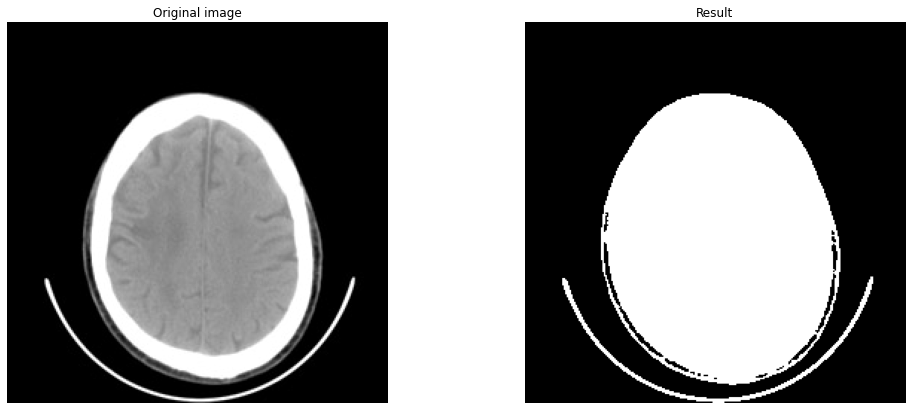

In [7]:
from matplotlib import pyplot as plt
from skimage.filters import threshold_mean
from skimage import data
import cv2

# Example 1: Here the mean works
image = data.camera()

# Example 2: Here the mean does not work
image = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)

thresh = threshold_mean(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=2, figsize=(17, 7))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

### Simple Thresholds in OpenCV

In [8]:
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual

modes = [
    'cv2.THRESH_BINARY',
    'cv2.THRESH_BINARY_INV',
    'cv2.THRESH_TRUNC',
    'cv2.THRESH_TOZERO',
    'cv2.THRESH_TOZERO_INV'
]

# Set the figure size, remembering that matplotlib 
# uses INCHES and not pixels...
matplotlib.rcParams['figure.figsize'] = [12,12]
 
# Read image
src = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)
  
# Basic threshold example
def my_threshold(thresh, modeStr):
    global src
    mode = eval(modeStr)
    th, dst = cv2.threshold(src, thresh, 255, mode)
    fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(src,'gray')
    ax[1].imshow(dst,'gray')

# Pass function & its parameters to interactive
interactive(my_threshold, thresh = (0, 255), modeStr=modes)

interactive(children=(IntSlider(value=127, description='thresh', max=255), Dropdown(description='modeStr', opt…

### Adaptive Thresholds in OpenCV

In [9]:
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual

modes = [
    'cv2.THRESH_BINARY',
    'cv2.THRESH_BINARY_INV',
    'cv2.THRESH_TRUNC',
    'cv2.THRESH_TOZERO',
    'cv2.THRESH_TOZERO_INV'
]

adaptModes = [
    'cv2.ADAPTIVE_THRESH_MEAN_C',
    'cv2.ADAPTIVE_THRESH_GAUSSIAN_C'
]


# Set the figure size, remembering that matplotlib 
# uses INCHES and not pixels...
matplotlib.rcParams['figure.figsize'] = [8,8]
 
# Read image
src = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)
  
# Basic threshold example
def my_adaptThreshold(adaptModeStr, modeStr, neighborhood, offset=0):
    global src
    mode = eval(modeStr)
    adaptMode = eval(adaptModeStr)
    dst = cv2.adaptiveThreshold(src, 255, adaptMode, mode, neighborhood, offset)
    fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(src,'gray')
    ax[1].imshow(dst,'gray')

    
# Pass function & its parameters to interactive
interactive(my_adaptThreshold, adaptModeStr=adaptModes, modeStr=modes, neighborhood=(3,31,2), offset=(-10,10,1))



interactive(children=(Dropdown(description='adaptModeStr', options=('cv2.ADAPTIVE_THRESH_MEAN_C', 'cv2.ADAPTIV…

### Adaptive Thresholds in SciKit

SciKit only can do mean-based adaptive thresholding. 

In [10]:
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu, threshold_local
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual

image = data.page()
# Read image
# image = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)


# Basic threshold example
def my_scikitAdaptThreshold(neighborhood):
    global image
    
    global_thresh = threshold_otsu(image)
    binary_global = image > global_thresh

    adaptative_mask = threshold_local(image, neighborhood, offset=0, method='mean')
    binary_local = image.copy()
    binary_local[adaptative_mask >= image] = 0.
    binary_local[adaptative_mask < image] = 1.

    fig, axes = plt.subplots(ncols=3, figsize=(20, 8))
    ax0, ax1, ax2 = axes
    plt.gray()

    ax0.imshow(image)
    ax0.set_title('Image')

    ax1.imshow(binary_global)
    ax1.set_title('Global thresholding')

    ax2.imshow(binary_local)
    ax2.set_title('Adaptive thresholding')

    for ax in axes:
        ax.axis('off')

    plt.show()
    
# Pass function & its parameters to interactive
interactive(my_scikitAdaptThreshold, neighborhood=(3,31,2))

interactive(children=(IntSlider(value=17, description='neighborhood', max=31, min=3, step=2), Output()), _dom_…

## Histogram Thresholds

### Histogram Thresholds in SciKit #1: Bimodal based upon the Global Minimum

For pictures with a bimodal histogram, more specific algorithms can be used.
For instance, the minimum algorithm takes a histogram of the image and smooths it
repeatedly until there are only two peaks in the histogram.


In [11]:
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_minimum
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual


image = data.camera()

def my_histo_threshold(bins):
    global image

    thresh_min = threshold_minimum(image, bins)
    binary_min = image > thresh_min

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    ax[0, 0].imshow(image, cmap=plt.cm.gray)
    ax[0, 0].set_title('Original')

    ax[0, 1].hist(image.ravel(), bins=bins)
    ax[0, 1].set_title('Histogram')

    ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
    ax[1, 0].set_title('Thresholded (min)')

    ax[1, 1].hist(image.ravel(), bins=bins)
    ax[1, 1].axvline(thresh_min, color='r')

    for a in ax[:, 0]:
        a.axis('off')
    plt.show()

    
# Pass function & its parameters to interactive
interact_manual(my_histo_threshold, bins=(2, 256))

interactive(children=(IntSlider(value=129, description='bins', max=256, min=2), Button(description='Run Intera…

<function __main__.my_histo_threshold(bins)>

### Histogram Thresholds in SciKit #2: Bimodal based upon the Otsu's and a Collection of other Methods

Otsu's method [1] calculates an "optimal" threshold (marked by a red line in the histogram below) performing a Cluster Analysis that maximizes the variance between two classes of pixels, which are separated by the threshold. Equivalently, clustering method minimizes the intra-class variance.

.. [1] http://en.wikipedia.org/wiki/Otsu's_method


In [12]:
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu, threshold_yen, threshold_isodata, threshold_li, threshold_triangle
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual

methods = [
    'threshold_otsu(image, bins)',
    'threshold_yen(image, bins)',
    'threshold_isodata(image, bins)',
    'threshold_li(image)',
    'threshold_triangle(image, bins)'
]


image = data.camera()
# Read image
# image = cv2.imread("../data/ct-01.jpg", cv2.IMREAD_GRAYSCALE)


def my_potpourri(method, bins):
    global image
    
    # Eval it!
    thresh = eval(method)
    # Generate a binary image 
    binary = image > thresh

    fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=bins)
    ax[1].set_title('Histogram '+str(bins))
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded: '+ method)
    ax[2].axis('off')

    plt.show()
    
# Pass function & its parameters to interactive
interact_manual(my_potpourri, method=methods, bins=(2, 256))

interactive(children=(Dropdown(description='method', options=('threshold_otsu(image, bins)', 'threshold_yen(im…

<function __main__.my_potpourri(method, bins)>

# Credits

* The OpenCV grayscale threshold examples were adapted from the following material:
  * https://www.learnopencv.com/opencv-threshold-python-cpp/
  * https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
* The SciKit grayscale threshold examples were adapted from the following materail:
  * https://scikit-image.org/docs/0.12.x/auto_examples/segmentation/plot_threshold_adaptive.html
  * https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_thresholding.html

![rodape lapix ufsc](../rodape-CC.png)